# Final Project

### DTSA 5510: Unsupervised Algorithms in Machine Learning

### December 9 2025

#### Data Source: https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots/data

### Problem Statement

Movie Genres fail to capture accurate themes for 2 reasons:

1. They're too broad.

2. Genres are missing or unknown.

Using Unsupervised Machine Learning it's possible to analyze movie plots and discover these Sub-Genres. BERTopic will be used to to discover these granular genres without manual classication.

## Load Dependencies

In [1]:
%%capture
!pip install bertopic

In [2]:
%%capture
!python -m spacy download en_core_web_sm

In [3]:
import torch
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Version in Torch: {torch.version.cuda}")

PyTorch Version: 2.9.0+cu126
CUDA Version in Torch: 12.6


In [4]:
import torch

cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

if cuda_available:
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

CUDA Available: True
Number of GPUs available: 1
GPU Name: NVIDIA A100-SXM4-40GB


In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from bertopic import BERTopic

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


# Exploratory Data Analysis

There are 34,886 rows and 8 columns in this dataset.

**Dataset Column Descriptions:**


**Release Year** - Year in which the movie was released

**Title** - Movie title

**Origin/Ethnicity** - Origin of movie (i.e. American, Bollywood, Tamil, etc.)

**Director** - Director(s)

**Genre** - Movie Genre(s)

**Wiki Page** - URL of the Wikipedia page from which the plot description was scraped

**Plot** - Long form description of movie plot (WARNING: May contain spoilers!!!)

There are 34886 rows and 8 columns in this dataset.


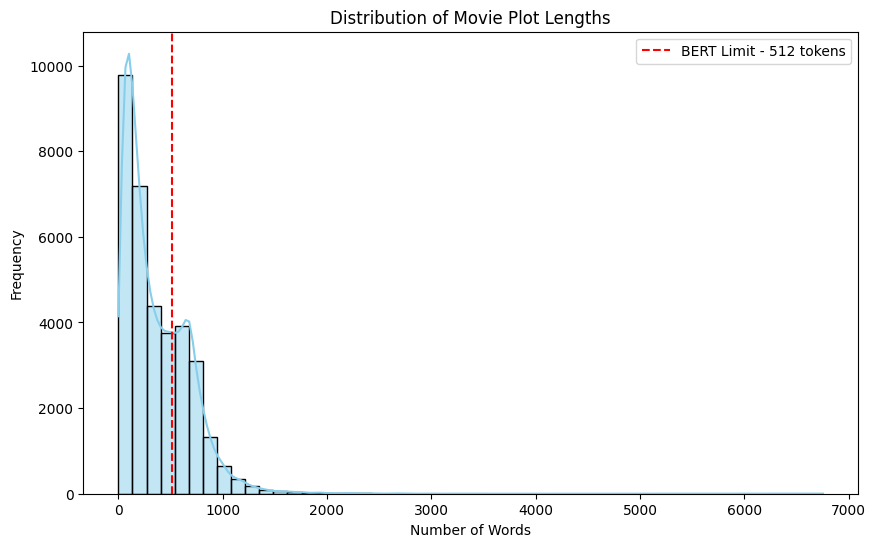

In [6]:
df = pd.read_csv('wiki_movie_plots_deduped.csv')
print("There are {} rows and {} columns in this dataset.".format(*df.shape))

# Calculate Word Counts
df['word_count'] = df['Plot'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['word_count'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Movie Plot Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.axvline(x=512, color='r', linestyle='--', label='BERT Limit - 512 tokens')
plt.legend()
plt.show()

#### Most of the movie plots fall within the 512 token limit of BERT.
#### Anything longer will be truncated.

### Plots with fewer than 20 words:


In [7]:
short_plots = df[df['word_count'] <= 20]

print(f"Number of short plots: {len(short_plots)}")
print("\n Examples:")
for i, plot in enumerate(short_plots['Plot'].head(10)):
    print(f"{i+1}. {plot}")

Number of short plots: 683

 Examples:
1. The story as told by Moving Picture World reads:

2. Described as "a liberal adaptation of Mrs. Shelley's famous story", the plot description in the Edison Kinetogram was:[3]
3. The following plot synopsis was published in conjunction with a 1915 showing of the film at Carnegie Hall:
4. Considered a coward by his fiancée and comrades in arms, a British army officer has to redeem himself.
5. A farm youth goes to college, pursues the pretty co-eds and joins a fraternity.
6. Luke (Harold Lloyd) works in a shoe store, but has difficulty focusing on work when a pretty girl is near.
7. Lonesome Luke (Harold Lloyd) tries to sell books to a businessman and his wife.
8. The film is about a court case and embezzlement.
9. Bebe plays a pretty young thing with several suitors, including Harold, competing to win her affections.
10. The plot of Experience was summarized in the August 1921 issue of Photoplay magazine.


Plots that are fewer than 20 words are not very helpful and will be removed.

### Top Genres in Dataset

In [8]:
# Load spacy model
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

df_clean = df[df['word_count'] > 20].copy()
print(f"Rows after dropping short plots: {len(df_clean)}")

# Common phrases to remove
custom_blocklist = [
    "forms the rest of the story",
    "forms the crux of the story",
    "the film tells the story",
    "the story as told by",
    "the plot description",
    "the film ends with",
    "post-credits scene",
    "post credits scene",
    "plot synopsis"
]

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)

    for phrase in custom_blocklist:
        text = text.replace(phrase, "")

    text = re.sub(r'\s+', ' ', text).strip()

    return text

df_clean['clean_plot'] = df_clean['Plot'].apply(clean_text)

# Check if blocklist terms have been removed
check_phrase = "forms the rest of the story"
print(f"Does the phrase '{check_phrase}' still exist? {df_clean['clean_plot'].str.contains(check_phrase).any()}")

Rows after dropping short plots: 34203
Does the phrase 'forms the rest of the story' still exist? False


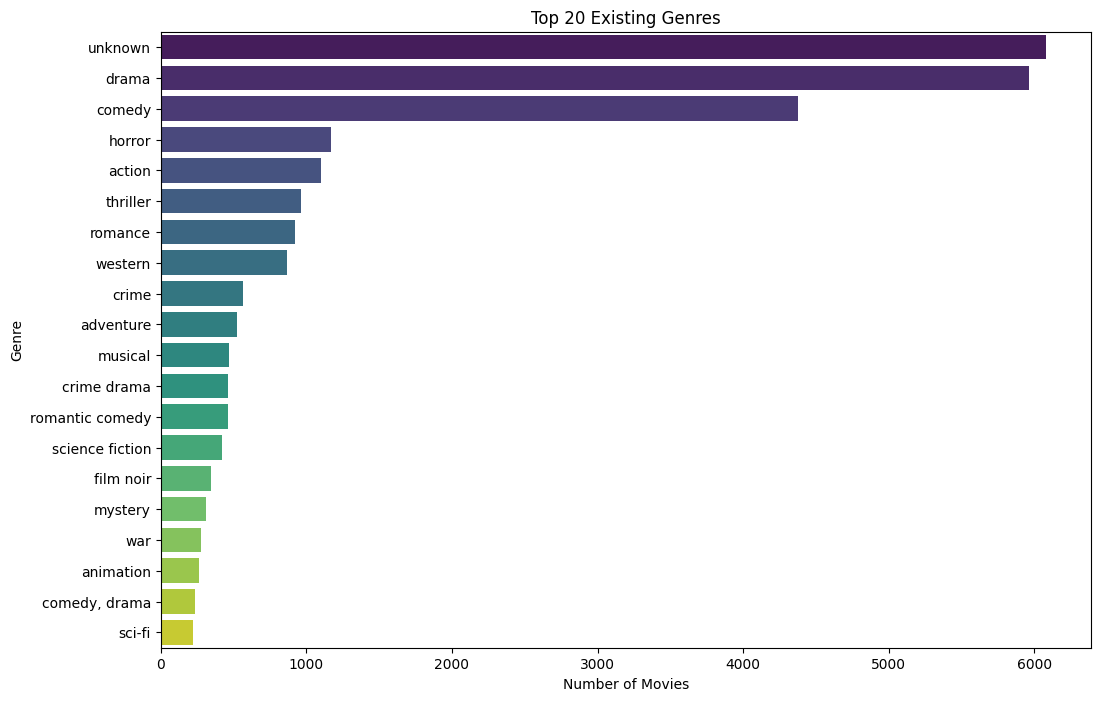

In [9]:
top_genres = df['Genre'].value_counts().head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_genres.values, y=top_genres.index, palette='viridis')
plt.title('Top 20 Existing Genres')
plt.xlabel('Number of Movies')
plt.show()

It looks like 'Unknown' is the largest Genre in this dataset. This is unhelpful and why our unsupervised approach on the actual plots will be so useful.

I'll remove stop words and see what the most common bigrams and trigrams are.

Bigrams are consecutive 2-word tokens.

Trigrams are consecutive 3-word tokens.

It'll give me an idea of what kind of multi-word phrases exist in the dataset.

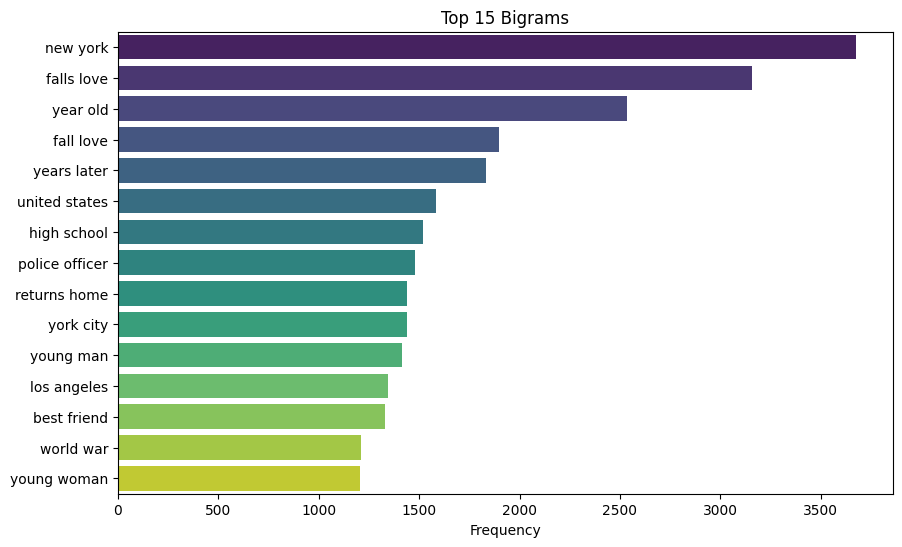

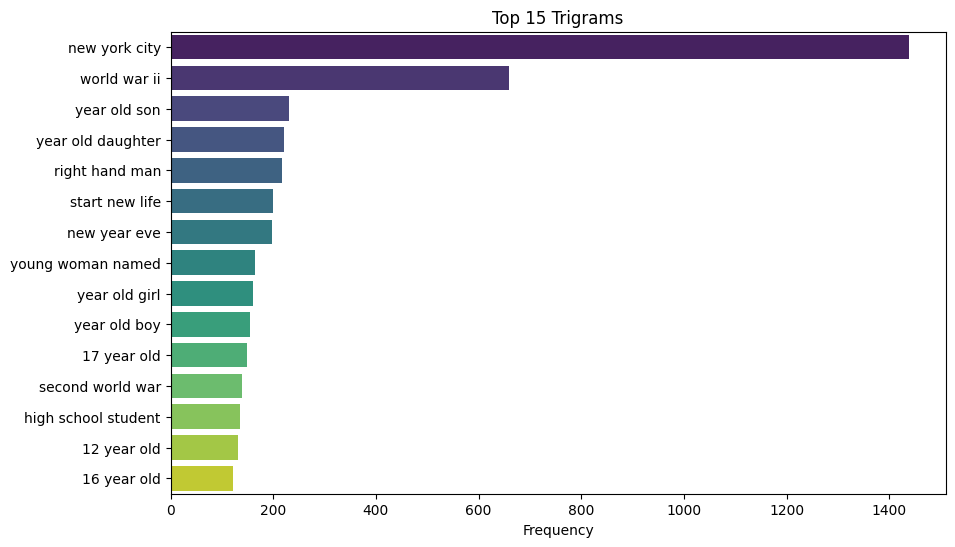

In [10]:
def plot_top_ngrams(corpus, n=2, title="Top Bigrams"):
    # create vectorizer
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(corpus)

    # Count words
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)

    # Sort words
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:15]

    x, y = map(list, zip(*words_freq))
    plt.figure(figsize=(10, 6))
    sns.barplot(x=y, y=x, palette='viridis')
    plt.title(title)
    plt.xlabel('Frequency')
    plt.show()

# Bigrams
plot_top_ngrams(df_clean['clean_plot'], n=2, title="Top 15 Bigrams")

# Trigrams
plot_top_ngrams(df_clean['clean_plot'], n=3, title="Top 15 Trigrams")

## Time Series Overview

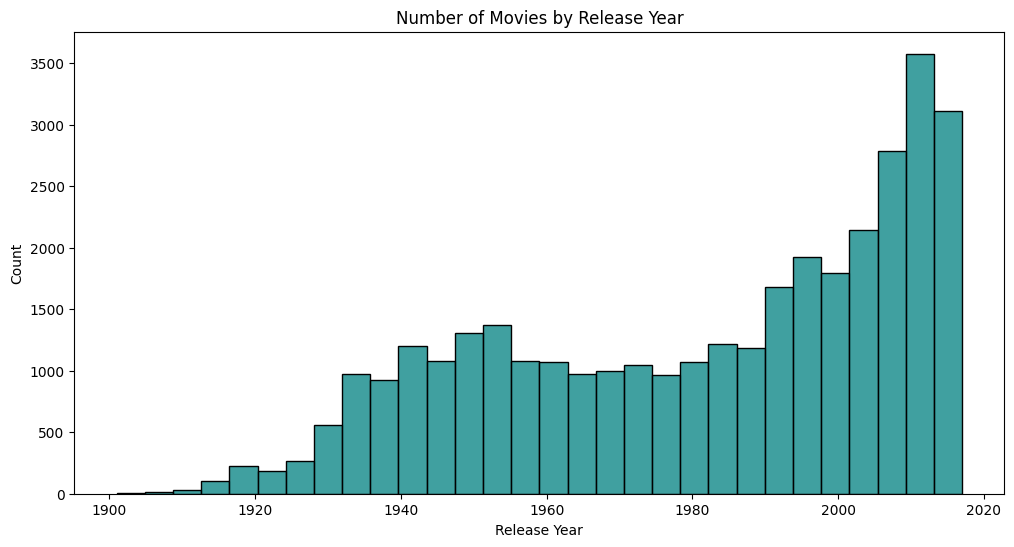

In [11]:
plt.figure(figsize=(12, 6))
sns.histplot(df['Release Year'], bins=30, color='teal')
plt.title('Number of Movies by Release Year')
plt.show()

# Model Building

At a high level the pipeline will do the following:

Convert text into vectors using Vectorization.

Dimensionality reduction using UMAP to project high dimensional embeddings into lower dimensinoal space.

Embeddings are clustered using HDBSCAN.

In [12]:
# Create Vectorizer
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3))

# Initialize BertTopic
topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    language="english",
    calculate_probabilities=False,
    verbose=True,
    min_topic_size=15
)

# Train Model
topics, probs = topic_model.fit_transform(df_clean['clean_plot'].tolist())

freq = topic_model.get_topic_info()
print(f"Number of topics found: {len(freq)}")
print(freq.head(10))

2025-12-09 03:14:57,723 - BERTopic - Embedding - Transforming documents to embeddings.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1069 [00:00<?, ?it/s]

2025-12-09 03:25:04,641 - BERTopic - Embedding - Completed ✓
2025-12-09 03:25:04,642 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-09 03:25:35,698 - BERTopic - Dimensionality - Completed ✓
2025-12-09 03:25:35,699 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-09 03:25:39,063 - BERTopic - Cluster - Completed ✓
2025-12-09 03:25:39,072 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-09 03:27:06,783 - BERTopic - Representation - Completed ✓


Number of topics found: 127
   Topic  Count                          Name  \
0     -1  13693       -1_tells_new_home_house   
1      0   9075     0_love_father_family_gets   
2      1   1125    1_hong_kong_hong kong_wong   
3      2    913        2_town_horse_men_ranch   
4      3    849   3_police_murder_killed_case   
5      4    508       4_film_story_young_love   
6      5    449       5_kim_korean_kang_korea   
7      6    355    6_ship_captain_crew_island   
8      7    306  7_dr_jekyll_hospital_michael   
9      8    264    8_ichi_samurai_yakuza_clan   

                                      Representation  \
0  [tells, new, home, house, later, finds, man, f...   
1  [love, father, family, gets, son, comes, villa...   
2  [hong, kong, hong kong, wong, li, chinese, wan...   
3  [town, horse, men, ranch, sheriff, cattle, gen...   
4  [police, murder, killed, case, car, detective,...   
5  [film, story, young, love, man, family, woman,...   
6  [kim, korean, kang, korea, lee, park,

# **Visualizations**

This BERTopic method shows all topics genres as bubbles.

Big bubbles = Popular topics.

Bubbles close together = Similar themes.

In [13]:
# Intertopic Distance Map
fig1 = topic_model.visualize_topics()
fig1.show()

# Hierarchical Clustering
fig2 = topic_model.visualize_hierarchy(top_n_topics=30)
fig2.show()

# Topic Bar Chart
# Top keywords for specific topics
fig3 = topic_model.visualize_barchart(top_n_topics=20)
fig3.show()

### Topics Over Time

In [14]:
# Topics Over Time
topics_over_time = topic_model.topics_over_time(
    df_clean['clean_plot'].tolist(),
    df_clean['Release Year'].tolist(),
    nr_bins=20,
    global_tuning=False,
    evolution_tuning=False
)

20it [06:40, 20.00s/it]


In [15]:
# Topics Over Time
fig_heatmap = topic_model.visualize_topics_over_time(
    topics_over_time,
    top_n_topics=20,
    normalize_frequency=True,
    custom_labels=True
)
fig_heatmap.show()

In [16]:
topic_info = topic_model.get_document_info(df_clean['clean_plot'])

# Assign Topic Names back to original dataframe
df_clean['Predicted_Topic'] = topic_info['Name'].values

# Filter for 'unknown' genres using the original dataframe
unknown_movies = df_clean[df_clean['Genre'] == 'unknown']

print(f"Solving the 'Unknown' Genre Problem (Sample of {len(unknown_movies)} movies)")
for index, row in unknown_movies.sample(5).iterrows():
    print(f"\nMovie: {row['Title']} ({row['Release Year']})")
    print(f"Original Genre: {row['Genre']}")
    print(f"New Unsupervised Label: {row['Predicted_Topic']}")

Solving the 'Unknown' Genre Problem (Sample of 5933 movies)

Movie: Zatoichi's Pilgrimage (1966)
Original Genre: unknown
New Unsupervised Label: 8_ichi_samurai_yakuza_clan

Movie: Filth (2013)
Original Genre: unknown
New Unsupervised Label: 76_batman_superman_lois_joker

Movie: Upendra (1999)
Original Genre: unknown
New Unsupervised Label: 0_love_father_family_gets

Movie: Thirumal Perumai (1968)
Original Genre: unknown
New Unsupervised Label: 0_love_father_family_gets

Movie: God Help the Girl (2014)
Original Genre: unknown
New Unsupervised Label: -1_tells_new_home_house


# Conclusion

The goal was to handle unlabelled data using a unsupervised approach. In the original dataset The single largest 'genre' category was unknown, making it tough to analyze.

My unsupervised pipeline, using BERTopic, was able to correctly classify these previously unknown datapoints in an automated way.

As demonstrated in the cell above, looking at these examples where the movie genre was originally classified as unknown, we now have accurate granular labels. The model was able to sucessfully generate these themes using the movies plot.